# Test all
This is a place to test all the inference methods and compare them apples-to-apples.

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join
import numpy as np
import sklearn.neighbors as skn
from sklearn.linear_model import LinearRegression
import tqdm
from scipy.stats import norm
import json

import torch
import torch_geometric as pyg
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
import sbi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('style.mcstyle')
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cpu


In [2]:
import ili
from ili.dataloaders import NumpyLoader, StaticNumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.metrics import PlotSinglePosterior, PosteriorCoverage
from ili.utils import IndependentTruncatedNormal, Uniform, IndependentNormal

from tools.plot_tools import binned_plot

## Load data

In [118]:
test = './configs/dat/summ_test.yaml'
test_loader = StaticNumpyLoader.from_config(test)
x = test_loader.get_all_data()
theta = test_loader.get_all_parameters()
Ngal = x[:,-1]

print(x.shape, theta.shape)


# prior = Uniform(low=[13.9], high=[14.85])
prior = IndependentNormal(loc=[13.94], scale=[0.373])
# proposal = IndependentTruncatedNormal(
#     low=[13.93], high=[14.8], loc=[13.6993], scale=[0.3166])

(59, 25) (59, 1)


## Load model predictions

In [154]:
samples = {}

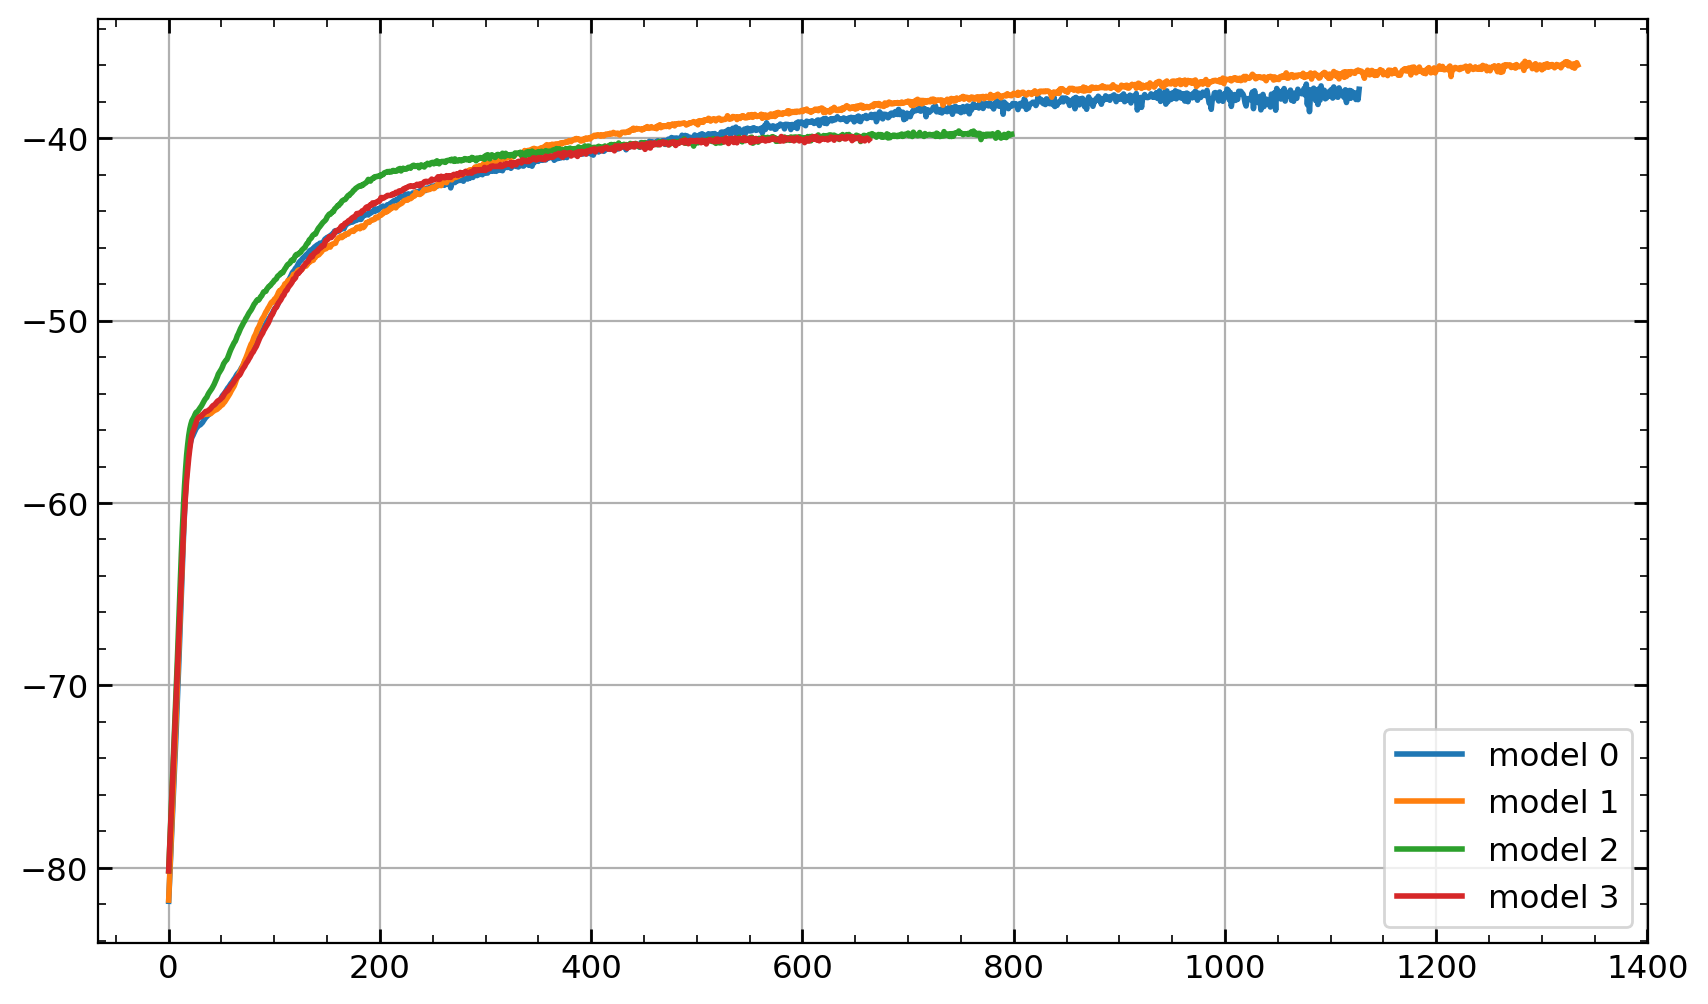

In [155]:
modeldir = './saved_models/summ_nle_dC100/'
summary = json.load(open(join(modeldir, 'summary.json'), 'r'))

for i, x in enumerate(summary):
    plt.plot(x['validation_log_probs'], label=f'model {i}')
plt.legend()

samples['summ'] = np.load(join(modeldir, 'posterior_samples.npy'))

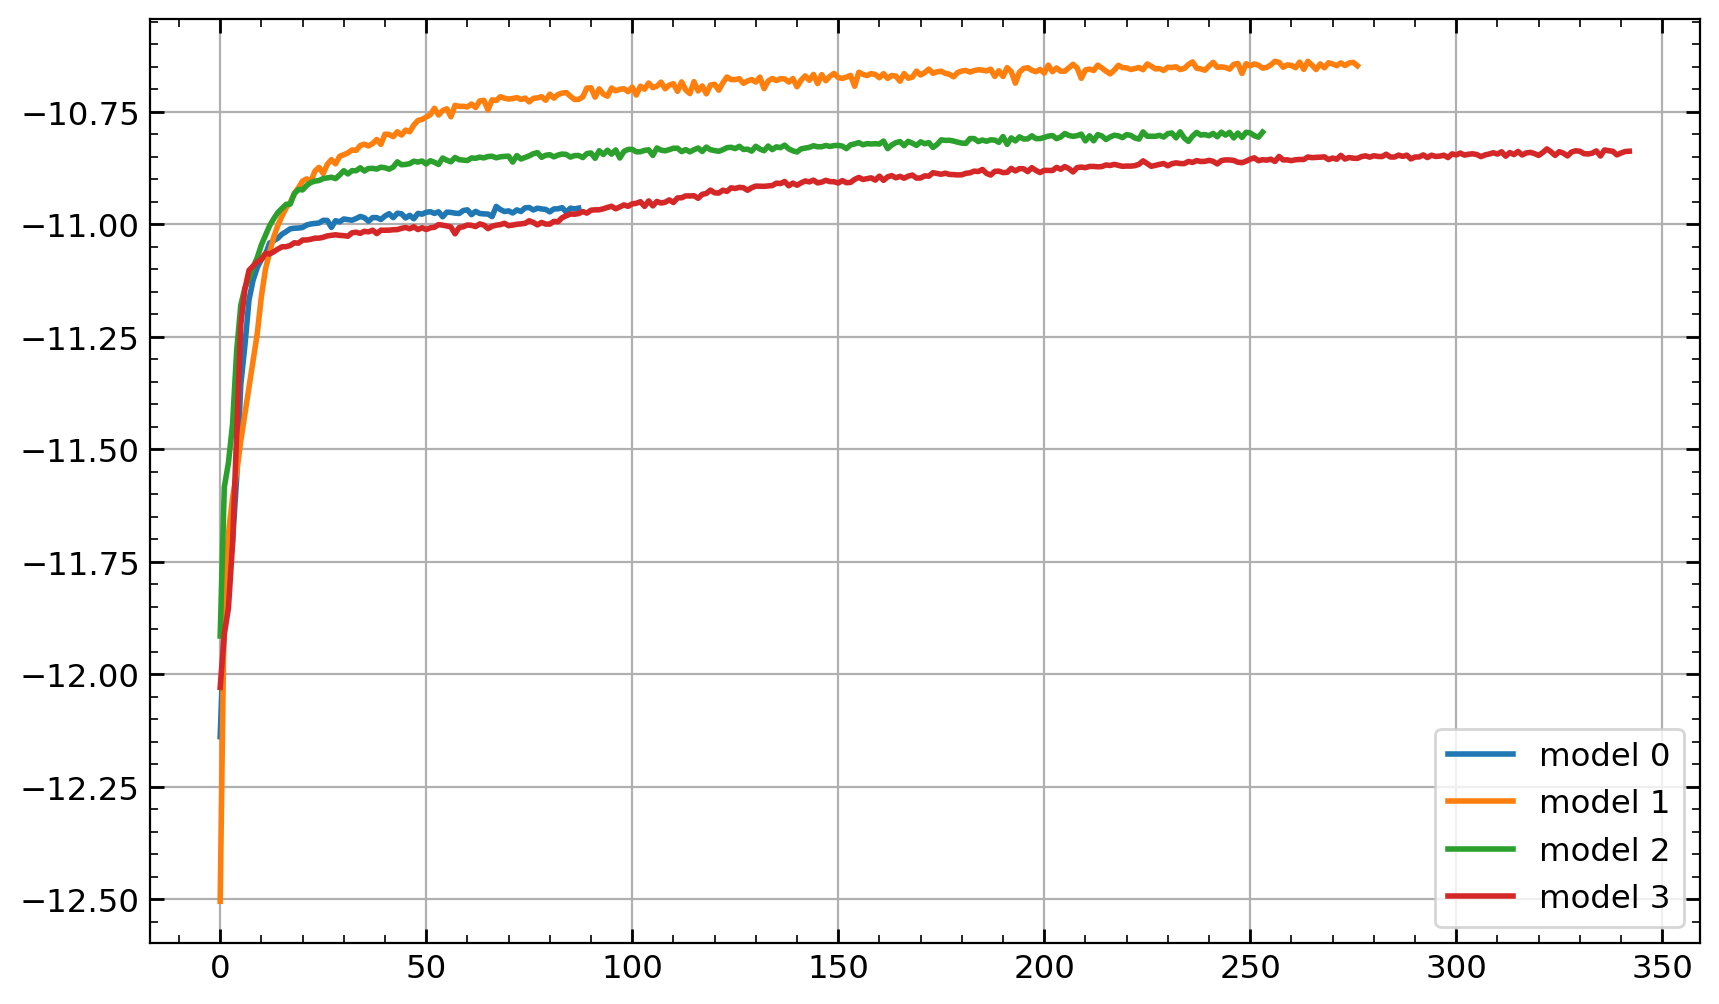

In [156]:
modeldir = './saved_models/gals_nle_dC100/'
summary = json.load(open(join(modeldir, 'summary.json'), 'r'))

for i, x in enumerate(summary):
    plt.plot(x['validation_log_probs'], label=f'model {i}')

plt.legend();

samples['gals'] = np.load(join(modeldir, 'posterior_samples.npy'))

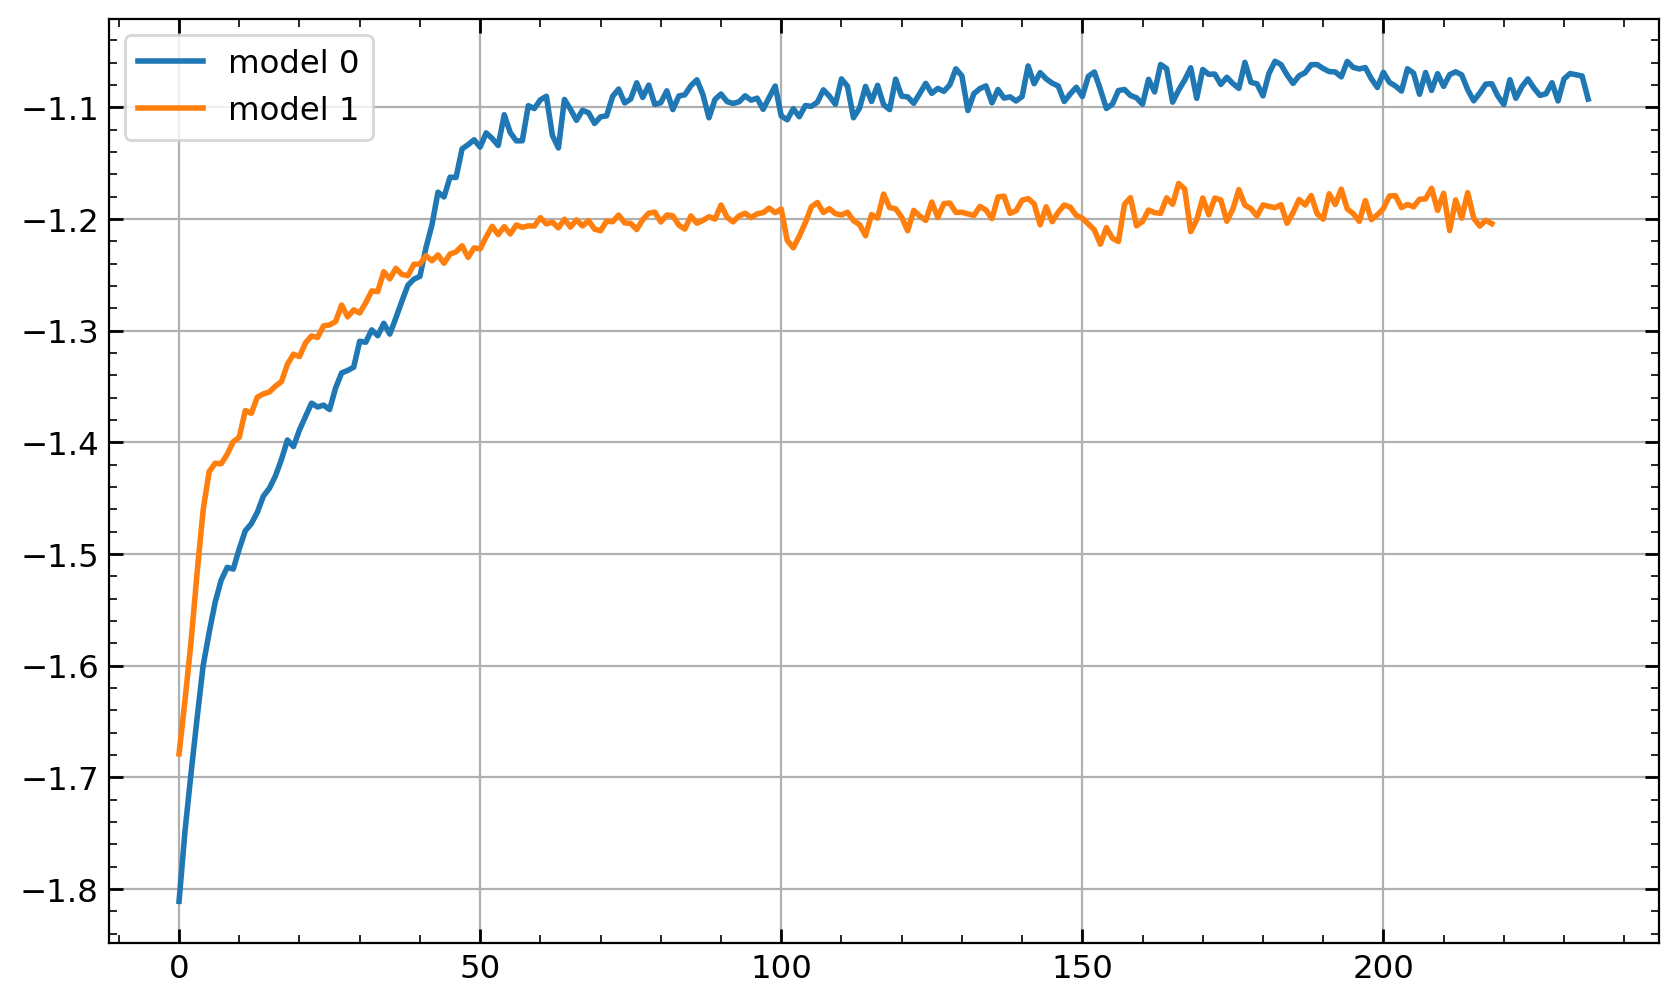

In [157]:
modeldir = './saved_models/gnn_npe_dC100/'
summary = json.load(open(join(modeldir, 'summary.json'), 'r'))

for i, x in enumerate(summary):
    plt.plot(x['validation_log_probs'], label=f'model {i}')

plt.legend();

samples['gnn'] = np.load(join(modeldir, 'posterior_samples.npy'))

## Compare predictions

In [158]:
# fit linear regressions
lrs = {}

for m, samps in samples.items():
    t_ = np.repeat(theta.T, len(samps), axis=0)

    lr = LinearRegression()
    lr.fit(t_.flatten()[:,None], samps.flatten())

    lrs[m] = lr

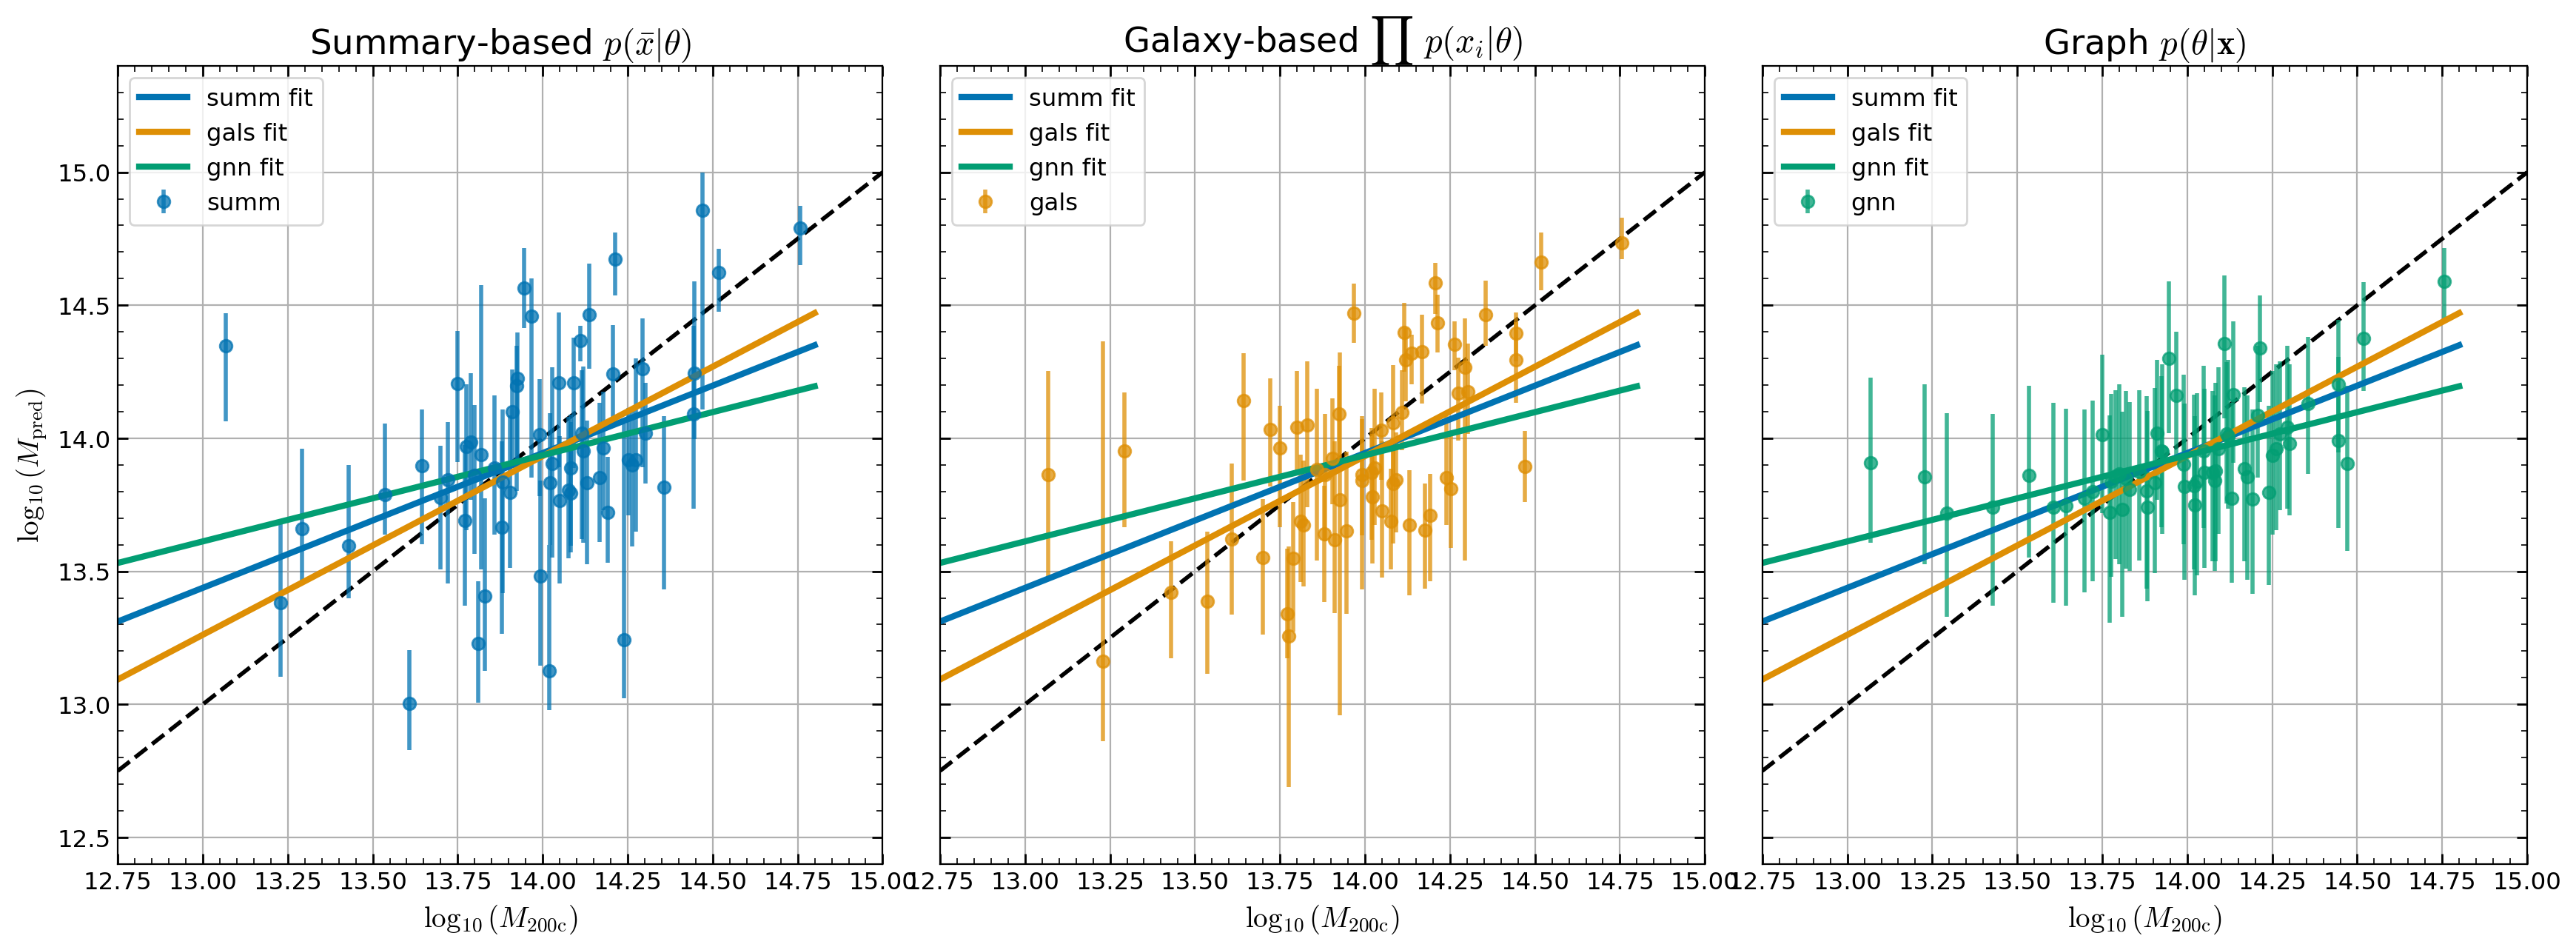

In [159]:
Nm = len(samples)
f, axs = plt.subplots(1, Nm, figsize=(7*Nm,7), sharey=True,
                      gridspec_kw={'wspace':0.075})

colors = sns.color_palette('colorblind', Nm)
for i, (m, samps) in enumerate(samples.items()):
    ax = axs[i]

    ax.plot([12.75,15], [12.75,15], 'k--')
    # plot with error bars
    median = np.median(samps, axis=0)[:,0]
    percs = np.percentile(samps, [16,84], axis=0)
    x_ = theta[:,0]
    ax.errorbar(x_, median, yerr=[median-percs[0,:,0], percs[1,:,0]-median],
                label=m, fmt='o', color=colors[i], alpha=0.75)

    # plot weighted linear regression
    x_ = np.linspace(12.5,14.8,100)
    for j, n in enumerate(samples.keys()):
        ax.plot(x_, lrs[n].predict(x_[:,None]), label=f'{n} fit',
                color=colors[j], lw=3)
    
    ax.legend()
    ax.set_xlim(12.75,15)
    ax.set_ylim(12.4,15.4)
    ax.set_xlabel(r'$\log_{10}(M_{\rm 200c})$')
    if i==0:
        ax.set_ylabel(r'$\log_{10}(M_{\rm pred})$');

axs[0].set_title(r'Summary-based $p(\bar{x}|\theta)$')
axs[1].set_title(r'Galaxy-based $\prod\ p(x_i|\theta)$')
axs[2].set_title(r'Graph $p(\theta|\mathbf{x})$');

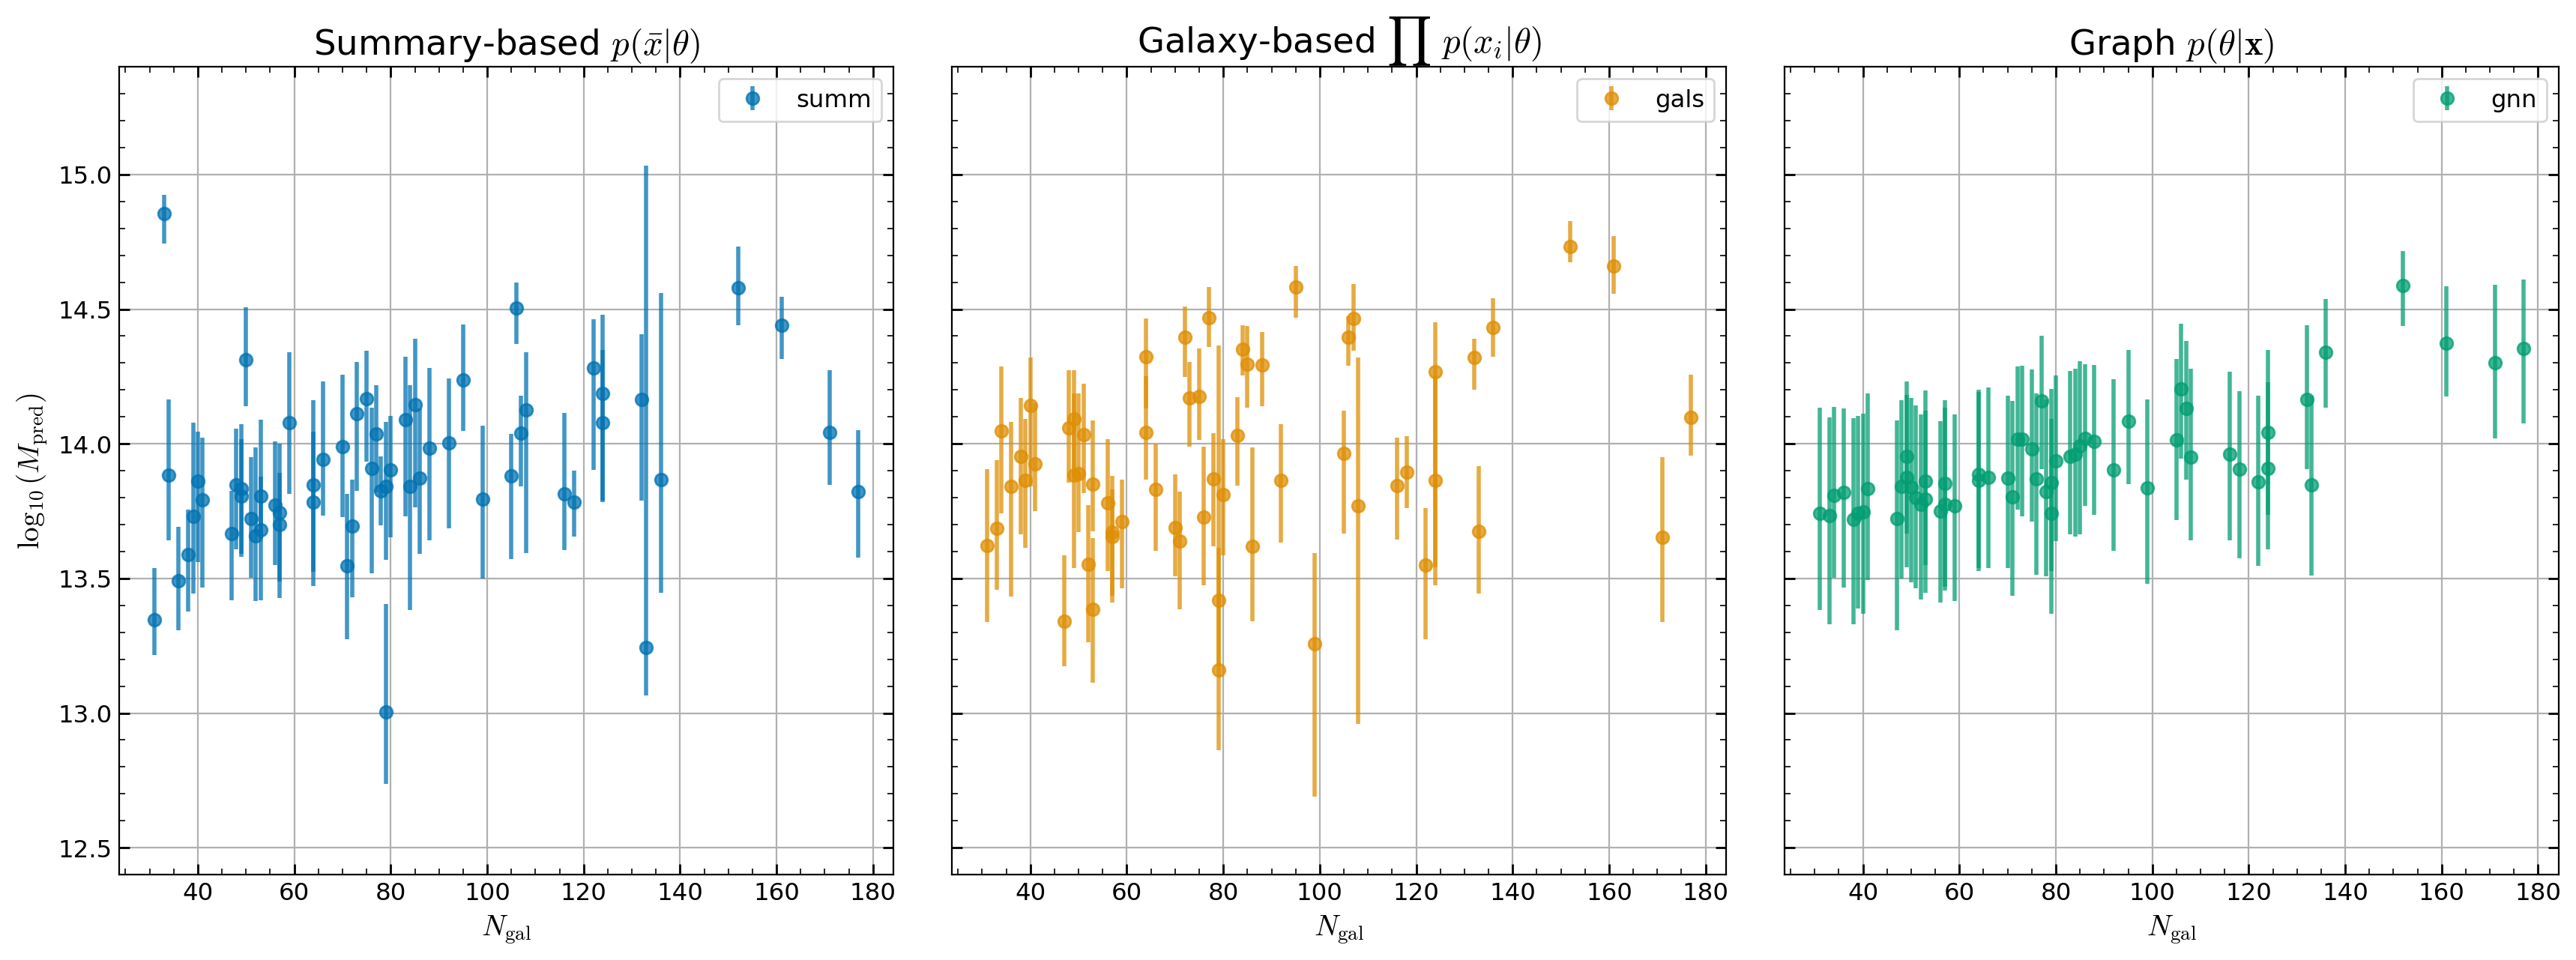

In [151]:
Nm = len(samples)
f, axs = plt.subplots(1, Nm, figsize=(7*Nm,7), sharey=True,
                      gridspec_kw={'wspace':0.075})

colors = sns.color_palette('colorblind', Nm)
for i, (m, samps) in enumerate(samples.items()):
    ax = axs[i]

    # plot with error bars
    median = np.median(samps, axis=0)[:,0]
    percs = np.percentile(samps, [16,84], axis=0)
    x_ = Ngal
    ax.errorbar(x_, median, yerr=[median-percs[0,:,0], percs[1,:,0]-median],
                label=m, fmt='o', color=colors[i], alpha=0.75)
    
    ax.legend()
    # ax.set_xlim(13.9,14.5)
    ax.set_ylim(12.4,15.4)
    ax.set_xlabel(r'$N_{\rm gal}$')
    if i==0:
        ax.set_ylabel(r'$\log_{10}(M_{\rm pred})$');

axs[0].set_title(r'Summary-based $p(\bar{x}|\theta)$')
axs[1].set_title(r'Galaxy-based $\prod\ p(x_i|\theta)$')
axs[2].set_title(r'Graph $p(\theta|\mathbf{x})$');

In [152]:
# Calculate scatter and correlation
t_ = theta[:,0]
sig = np.std(t_ - np.mean(t_))
print(f'Observed scatter: {sig:.3f}')

for m, samps in samples.items():
    mean = np.mean(samps, axis=0)[:,0]
    median = np.median(samps, axis=0)[:,0]

    print(' ')
    print(f'{m} mean scatter: {np.std(t_ - mean):.3f}')
    print(f'{m} median scatter: {np.std(t_ - median):.3f}')
    

Observed scatter: 0.311
 
summ mean scatter: 0.294
summ median scatter: 0.313
 
gals mean scatter: 0.288
gals median scatter: 0.289
 
gnn mean scatter: 0.260
gnn median scatter: 0.258


## Load data

In [85]:
dname = 'AMICOdC100' # 'Lorenzo' # 

datapath = join('data/processed', dname)
print('Loading from:', datapath)
x = np.load(join(datapath, 'x.npy'))
theta = np.load(join(datapath, 'theta.npy'))
fold = np.load(join(datapath, 'fold.npy'))
ids = np.load(join(datapath, 'id.npy'))

Loading from: data/processed/AMICOdC100


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/AMICOdC100/x.npy'

In [4]:
param_names = ['$\log_{10}M_{200c}$', '$ \log_{10}R_{200c}$']

data_names = ['x', 'y','v_{los}']

priors = np.array([[13.9, 14.8], [-0.31, 0.05]])

Rmax = 1.5

In [5]:
x_batch = [x[ids==i] for i in np.sort(np.unique(ids))]
N_batch = np.array([len(x_) for x_ in x_batch])
theta_batch = np.array([theta[ids==i][0] for i in np.sort(np.unique(ids))])
fold_batch = np.array([fold[ids==i][0] for i in np.sort(np.unique(ids))])

def get_adjacency(x, rmax=1.2):
    graph = skn.radius_neighbors_graph(x[:,:2], rmax, mode='distance', include_self=True).toarray()
    adj = np.nonzero(graph)
    return tuple(adj)

rmax=1.5
adj_batch = [get_adjacency(x_, rmax=rmax) for x_ in x_batch]

In [6]:
print('Number of unique galaxies:', len(x)) 
print('Number of unique clusters:', len(x_batch))

Number of unique galaxies: 24452
Number of unique clusters: 996


In [7]:
# focus on mass for now
theta = theta[:, 0:1]
theta_batch = theta_batch[:, 0:1]
param_names = param_names[0:1]

In [8]:
from scipy.optimize import minimize
eps=1e-6
thmin, thmax = np.min(theta[:,0])*(1-eps), np.max(theta[:,0])*(1+eps)
def func(x):
    prior = ili.utils.IndependentTruncatedNormal(loc=[x[0]], scale=[x[1]], 
                                                 low=[thmin], high=[thmax], 
                                                 device=device)
    return -np.sum(prior.log_prob(torch.Tensor(theta)).numpy())

pmu, pstd = minimize(func, x0=[13.8, 0.3], method='Nelder-Mead', tol=1e-6).x
print(f'Fitted prior mean: {pmu:.4f}, std: {pstd:.4f}')
pmu, pstd = [pmu], [pstd]

Fitted prior mean: 13.6993, std: 0.3166


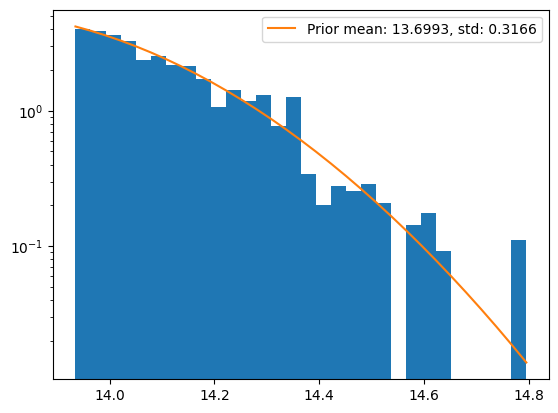

In [9]:
plt.semilogy()
h, bins, _ = plt.hist(theta, 30, density=True)

prior = IndependentTruncatedNormal(pmu, pstd, thmin, thmax)
y = [prior.log_prob(x).exp().numpy() for x in bins]
plt.plot(bins, y, label=f'Prior mean: {pmu[0]:.4f}, std: {pstd[0]:.4f}')
plt.legend()

In [10]:
# Prior scatter
pred = np.median(prior.sample(theta.shape).numpy())

print(f'Prior scatter: {np.std(pred-theta):.4f}')

Prior scatter: 0.1503


## M-$\sigma$

In [11]:
gapper = lambda x: np.sqrt(np.sum((x-np.mean(x))**2)/(len(x)-1))

logsigv_batch = np.log10([gapper(x_[:,2]) for x_ in x_batch])

In [12]:
# fit a linear regression
lr = LinearRegression().fit(theta_batch[:,0:1], logsigv_batch)

pi = lr.intercept_
alpha = lr.coef_[0]
res = logsigv_batch - lr.predict(theta_batch[:,0:1])
scatter = np.std(res) / np.abs(alpha)
ll = norm.logpdf(res, 0, np.std(res)).sum()

print(f'scatter: {scatter:.4f} dex')
print(f'log likelihood: {ll:.4f}')

scatter: 1.8029 dex
log likelihood: 297.9676


Text(0.5, 1.0, 'M-$\\sigma_v$ relation')

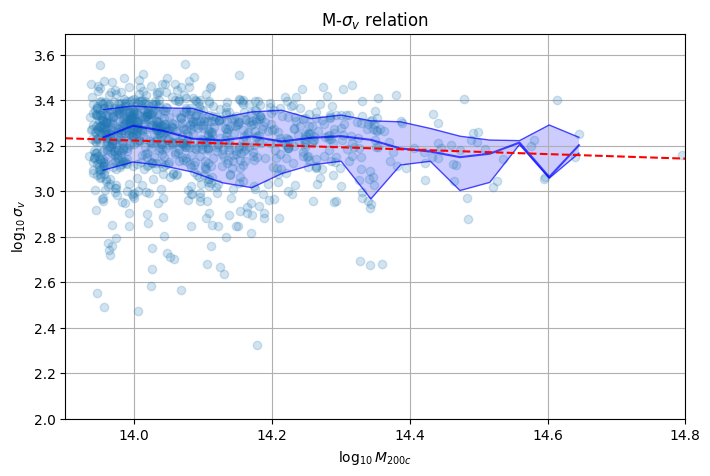

In [13]:
f, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(theta_batch[:,0], logsigv_batch, 'o', alpha=0.2)
_ = binned_plot(theta_batch[:,0], logsigv_batch, ax=ax, n=20, color='b')
ax.plot(priors[0], lr.predict(priors[0].reshape(-1,1)), 'r--')
ax.grid()
ax.set_xlim(*priors[0])
ax.set_ylim(2)
ax.set_xlabel(param_names[0])
ax.set_ylabel('$\log_{10}\sigma_v$')
ax.set_title('M-$\sigma_v$ relation')

## Galaxy-based NLE

In [14]:
ind = [0,1]
mask = np.isin(fold, ind)
train_loader = NumpyLoader(x=x[mask], theta=theta[mask])
test_loader = NumpyLoader(x=x[~mask], theta=theta[~mask])

x_test, theta_test = x[~mask], theta[~mask]

mask = np.isin(fold_batch, ind)
x_test_batch = [x_batch[i] for i in np.where(mask)[0]]
theta_test_batch = theta_batch[mask]

In [15]:
# define a prior
proposal = IndependentTruncatedNormal(pmu, pstd, thmin, thmax, validate_args=False)
prior = sbi.utils.BoxUniform(low=[thmin], high=[thmax], device='cpu')

# define an inference class (here, we are doing amortized likelihood inference)
inference_class = sbi.inference.SNLE

# instantiate your neural networks to be used as an ensemble
nets = [
    sbi.utils.likelihood_nn(model='maf', hidden_features=50, num_transforms=5),
    sbi.utils.likelihood_nn(model='nsf', hidden_features=50, num_transforms=5),
    # sbi.utils.likelihood_nn(model='mdn', hidden_features=50, num_components=3),
]

# define an embedding network
embedding_net = ili.embedding.FCN(n_data=3, n_hidden=[8,8])

# define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 5e-6
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    proposal=proposal,
    inference_class=inference_class,
    nets=nets,
    device=device,
    # embedding_net=embedding_net,
    train_args=train_args,
    output_path=None  # no output path, so nothing will be saved to file
)

In [16]:
# train the model. this outputs a posterior model and training logs
posterior, summaries = runner(loader=train_loader)

INFO:root:MODEL INFERENCE CLASS: SNLE_A
INFO:root:Training model 1 out of 2 ensemble models


 Training neural network. Epochs trained: 526

INFO:root:Training model 2 out of 2 ensemble models


 Training neural network. Epochs trained: 535527 epochs.

INFO:root:It took 788.277204990387 seconds to train all models.


 Neural network successfully converged after 536 epochs.

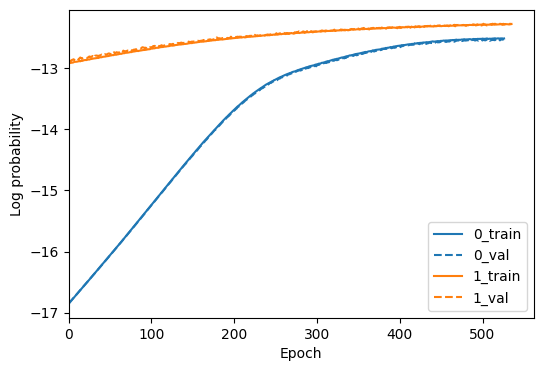

In [17]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Running vectorized MCMC with 6 chains:   0%|          | 0/1668 [00:00<?, ?it/s]

Running vectorized MCMC with 6 chains:   0%|          | 0/2058 [00:00<?, ?it/s]

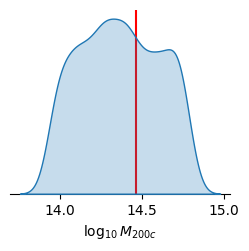

In [18]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='slice_np_vectorized',
    sample_params={'num_chains': 6, 'burn_in':20, 'thin': 3},
    labels=param_names
)
ind=105
fig = metric(
    posterior=posterior, 
    x_obs = x_test[ind], theta_obs=theta_test[ind], 
    x=x_test, theta=theta_test,
)

In [22]:
# calculate and plot the rank statistics to describe univariate posterior coverage
# (note, with MCMC this takes a while)
metric = PosteriorCoverage(
    backend='sbi', output_path=None, num_samples=100, 
    sample_method='slice_np_vectorized',
    sample_params={'num_chains': 6, 'burn_in':20, 'thin': 3},
    labels=param_names,
    plot_list=['coverage', 'predictions', 'histogram', 'logprob']
)
fig = metric(
    posterior=posterior,
    x=x[::200], theta=theta[::200]
)

  1%|          | 1/123 [00:11<23:23, 11.51s/it]


KeyboardInterrupt: 

In [23]:
Ntrue = len(x_test_batch)
samples = []
for i in tqdm.tqdm(range(Ntrue)):
    t = posterior.sample((100,), torch.Tensor(x_test_batch[i]).to(device),
                        method='slice_np_vectorized',
                        num_chains=6, warmup_steps=20, thin=3,
                        show_progress_bars=False).flatten()
    samples.append(t.cpu().numpy())

  0%|          | 0/207 [00:11<?, ?it/s]


KeyboardInterrupt: 

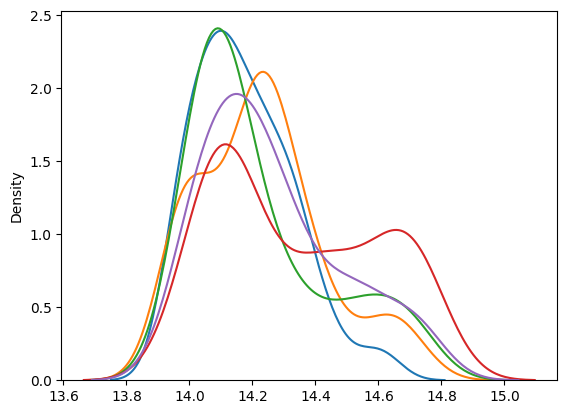

In [45]:
# plt.semilogy()
for i in range(5):
    _ = sns.kdeplot(samples[i])

(13.9, 14.8)

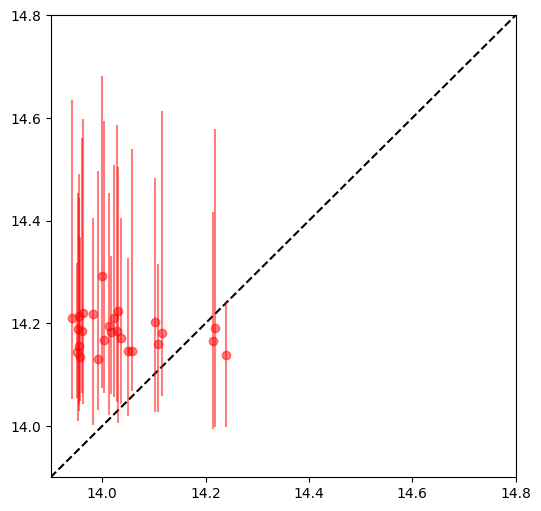

In [46]:
trues = theta_test_batch[:len(samples),0]
percs = np.percentile(samples, [16, 50, 84], axis=1)

f, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(priors[0], priors[0], 'k--')
ax.errorbar(trues, percs[1], yerr=[percs[1]-percs[0], percs[2]-percs[1]],
            fmt='ro', label='68%', alpha=0.5)
ax.set_xlim(*priors[0])
ax.set_ylim(*priors[0])

In [75]:
print(f'Galaxy-based NLE scatter: {np.std(percs[1]-trues):.4f}')

Galaxy-based NLE scatter: 0.1469


## Summary FCN

In [52]:
def calc_sum(x):
    feats = [x.sum(axis=0), x.mean(axis=0), x.std(axis=0),
             np.median(x, axis=0), x.min(axis=0), x.max(axis=0)]
    return np.concatenate(feats)

x_summ = np.array([calc_sum(x_) for x_ in x_batch])
x_summ

ind = [0,1]
mask = np.isin(fold_batch, ind)
train_loader = NumpyLoader(x=x_summ[mask], theta=theta_batch[mask])
test_loader = NumpyLoader(x=x_summ[~mask], theta=theta_batch[~mask])

x_test, theta_test = x_summ[~mask], theta_batch[~mask]

In [53]:
# define a prior
proposal = IndependentTruncatedNormal(pmu, pstd, thmin, thmax, validate_args=False)
prior = ili.utils.Uniform(low=[thmin], high=[thmax], device='cpu')

# define an inference class (here, we are doing amortized posterior inference)
inference_class = sbi.inference.SNPE

# instantiate your neural networks to be used as an ensemble
nets = [
    sbi.utils.posterior_nn(model='nsf', hidden_features=50, num_transforms=5),
    sbi.utils.posterior_nn(model='maf', hidden_features=50, num_transforms=5),
    sbi.utils.posterior_nn(model='mdn', hidden_features=50, num_components=3),
]

# define an embedding network
embedding_net = ili.embedding.FCN(n_data=x_summ.shape[-1], n_hidden=[16,16,16])

# define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 1e-3
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    proposal=proposal,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    output_path=None  # no output path, so nothing will be saved to file
)

In [54]:
posterior, summaries = runner(loader=train_loader)

INFO:root:MODEL INFERENCE CLASS: SNPE_C
INFO:root:Training model 1 out of 3 ensemble models


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 40

INFO:root:Training model 2 out of 3 ensemble models


 Neural network successfully converged after 42 epochs.Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 16

INFO:root:Training model 3 out of 3 ensemble models


 Neural network successfully converged after 22 epochs.Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 34

INFO:root:It took 2.229867935180664 seconds to train all models.


 Neural network successfully converged after 41 epochs.

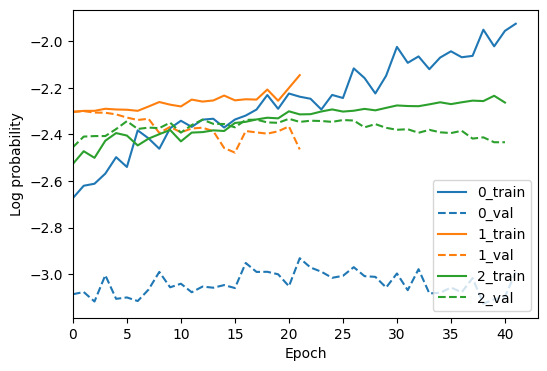

In [55]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Warmup [1]:   0%|          | 0/208 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/208 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/208 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/208 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/208 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/208 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/319 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/319 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/319 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/319 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/319 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/319 [00:00, ?it/s]

Warmup [1]:   0%|          | 0/290 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/290 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/290 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/290 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/290 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/290 [00:00, ?it/s]

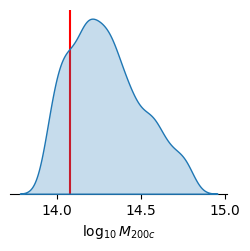

In [56]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='nuts',
    sample_params={'num_chains': 6, 'burn_in':100, 'thin': 3},
    labels=param_names
)
ind=0
fig = metric(
    posterior=posterior,
    x_obs=x_test[ind], theta_obs=theta_test[ind],
    x=x_test, theta=theta_test,
)

In [57]:
# calculate and plot the rank statistics to describe univariate posterior coverage
# (note, with MCMC this takes a while)
metric = PlotRankStatistics(
    backend='sbi', output_path=None, num_samples=100, 
    sample_method='direct',
    labels=param_names
)
fig = metric(
    posterior=posterior,
    x=x_summ, theta=theta_batch
)

NameError: name 'PlotRankStatistics' is not defined

In [137]:
Ntrue = len(x_test)
samples = []
for i in tqdm.tqdm(range(Ntrue)):
    t = posterior.sample((100,), torch.Tensor(x_test[i]).to(device),
                        show_progress_bars=False).flatten()
    samples.append(t.cpu().numpy())

100%|██████████| 789/789 [00:09<00:00, 86.92it/s]


(13.9, 14.8)

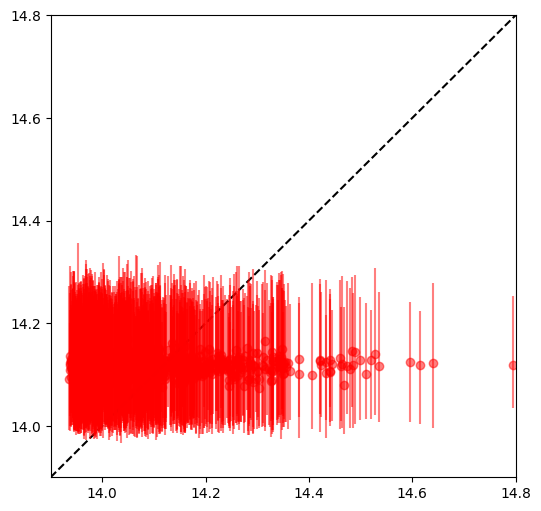

In [139]:
trues = theta_test[:len(samples),0]
percs = np.percentile(samples, [16, 50, 84], axis=1)

f, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(priors[0], priors[0], 'k--')
ax.errorbar(trues, percs[1], yerr=[percs[1]-percs[0], percs[2]-percs[1]],
            fmt='ro', label='68%', alpha=0.5)
ax.set_xlim(*priors[0])
ax.set_ylim(*priors[0])

In [140]:
print(f'Summary-based NLE scatter: {np.std(percs[1]-trues):.4f}')

Galaxy-based NLE scatter: 0.1350


## Graph NPE